In [1]:
from classification_probes import ActivationDataset, ProbeTrainer, TextClassificationDataset, HookManager, ClassificationProbe
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
from collections import defaultdict
from typing import Dict, List, Tuple, Any
from tqdm import tqdm
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import numpy as np
#import seaborn as sns

In [2]:
# Initialize Variables
model_name = "AI-Sweden-Models/gpt-sw3-126m"
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# Initialize Tokenizer & Model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model.eval()
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(64000, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): GELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=64000, bias=False)
)

In [3]:
lab_map = {
    'da': 0,
    'en': 1,
    'is': 2,
    'nb': 3,
    'sv': 4
}

map_lab = {value: key for key, value in lab_map.items()}

data_loc = 'data/antibiotic/'
ds = TextClassificationDataset.from_txt(data_loc + 'da.txt', lab_map['da'])
ds.add_from_txt(data_loc + 'en.txt', lab_map['en'])
#ds.add_from_txt(data_loc + 'is.txt', lab_map['is'])
#ds.add_from_txt(data_loc + 'nb.txt', lab_map['nb'])
#ds.add_from_txt(data_loc + 'sv.txt', lab_map['sv'])

meta_data = {}

loader = DataLoader(ds, batch_size=32, shuffle=True)
try:
    meta_data["hidden_size"] = model.config.n_embd
except AttributeError:
    meta_data["hidden_size"] = model.config.hidden_size


meta_data["hidden_layers"] = model.config.num_hidden_layers

In [4]:


class ActivationDataset(Dataset):

    def __init__(self):
        self.acts = []
        self.labels = []

        self.d = defaultdict(list)


    def add_with_mask(self, acts, labels, masks):
        for act, label, mask in zip(acts, labels, masks):
            if mask:
                self.d[label].append(act)

                self.acts.append(act)
                self.labels.append(label)

    def __getitem__(self, index) -> tuple:
        return (self.acts[index], self.labels[index])

    def __len__(self) -> int:
        return len(self.acts)


In [5]:
res_stream_act_by_layer = dict()
activation_ds_by_layer = {
    layer: ActivationDataset()
    for layer in range(meta_data["hidden_layers"])
}

for ind, (text, label) in enumerate(tqdm(loader)):

    if ind > 5:
        break

    tokenized = tokenizer(
        text,
        padding=True,
        truncation=True,
        return_tensors='pt'
    ).to(device)

    with HookManager(model) as hook_manager:
        for layer in range(meta_data["hidden_layers"]):
            res_stream_act_by_layer[layer] = hook_manager.attach_residstream_hook(
                layer=layer,
                pre_mlp=False,
                pythia=False
            )

        model(**tokenized)

    # flattening [batch, pad_size, ...] to [tokens, ...]
    attn_mask = tokenized.attention_mask.flatten() # [tokens]
    label = label.unsqueeze(-1).expand(-1, tokenized.attention_mask.shape[1]).flatten() # [tokens]

    for layer in range(meta_data["hidden_layers"]):
        res_stream_act_by_layer[layer] = res_stream_act_by_layer[layer][0].view(-1, meta_data["hidden_size"]) # [tokens, hidden_size]
        activation_ds_by_layer[layer].add_with_mask(res_stream_act_by_layer[layer], label, attn_mask)



  0%|          | 0/55 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
 11%|█         | 6/55 [00:04<00:37,  1.32it/s]


In [6]:
s = set()
for i in range(meta_data["hidden_layers"]):
    unique_labels = set(np.array(activation_ds_by_layer[i].labels))
    [s.add(x) for x in unique_labels]

In [7]:
learning_rate = 0.001
reg_lambda = 0.1
num_labs = len(s)


probe_by_layer = {
    layer: ClassificationProbe(in_dim=meta_data["hidden_size"], num_labs=num_labs, device=device)
    for layer in range(meta_data["hidden_layers"])
}

act_loader_by_layer = {
    layer: DataLoader(activation_ds_by_layer[layer], batch_size=32, shuffle=True)
    for layer in range(meta_data["hidden_layers"])
}


for layer, probe in probe_by_layer.items():
    act_loader = act_loader_by_layer[layer]
    optimizer = torch.optim.Adam(probe.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(1):
        for act, label in act_loader:

                    
            label = label.to(device)
            batch_size = label.shape[0]
            #This just fixed the batch slicing
            if batch_size != 32:
                break
            outputs = probe(act)
            preds = torch.argmax(outputs, dim=1)  # Get predicted class indices

            # Store labels and predictions (keep them on device)
            probe.all_preds.append(preds)
            probe.all_labels.append(label)

            loss = loss_fn(outputs, label.to(device))
            loss += reg_lambda * sum(torch.norm(param, 2) for param in probe.parameters())

            accuracy = ((torch.argmax(outputs.detach(), dim=1) == label.to(device)).sum() / batch_size).item()
            #print('acc: ', accuracy, end='\n')

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            #print(loss)
    probe.compute_scores()

In [8]:
probe.class_accuracies

# probe_by_layer = {
#     'Layer 1': {0: 0.9608, 1: 0.925},
#     'Layer 2': {0: 0.9300, 1: 0.910},
#     'Layer 3': {0: 0.9400, 1: 0.920},
#     'Layer 4': {0: 0.9500, 1: 0.930}
# }

{0: 0.9468354430379747, 1: 0.936296814840742}

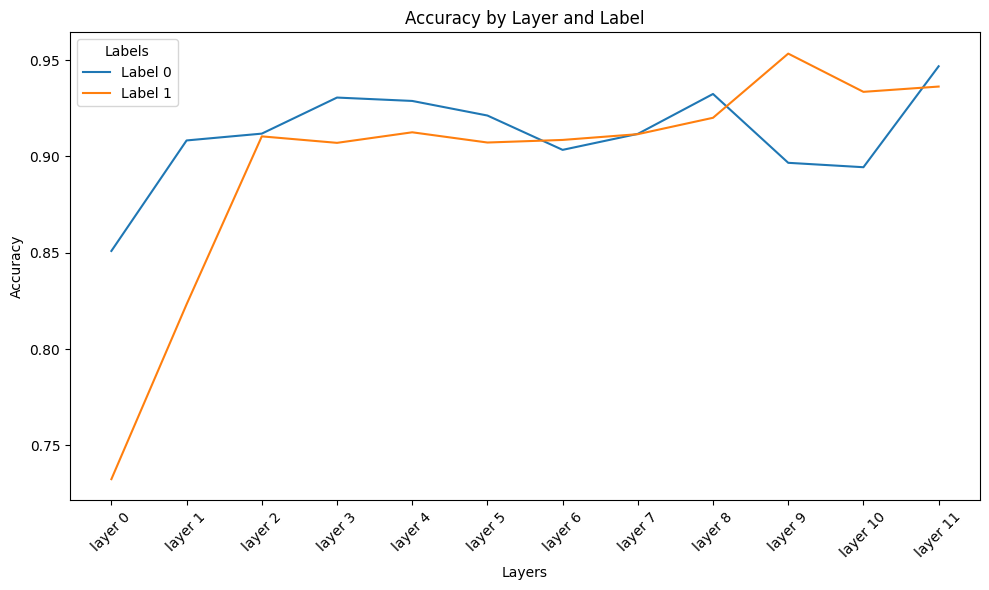

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Example structure of probe_by_layer
# This would typically be populated with the actual probes for your model layers


idk = {
    f"layer {i}": value.class_accuracies for i, value in enumerate(probe_by_layer.values())
}

# Convert the probe data to a DataFrame for easier handling
# Assuming `probe_by_layer` is a dictionary of {layer_name: {label: accuracy}}
df = pd.DataFrame(idk)

# Transpose the DataFrame so that labels are the columns
df = df.T

# Plotting
plt.figure(figsize=(10, 6))

# Loop through each label and plot a line for that label
for label in df.columns:
    plt.plot(df.index, df[label], label=f"Label {label}")

# Adding labels and title
plt.xlabel('Layers')
plt.ylabel('Accuracy')
plt.title('Accuracy by Layer and Label')
plt.legend(title='Labels')

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [10]:
import seaborn as sns


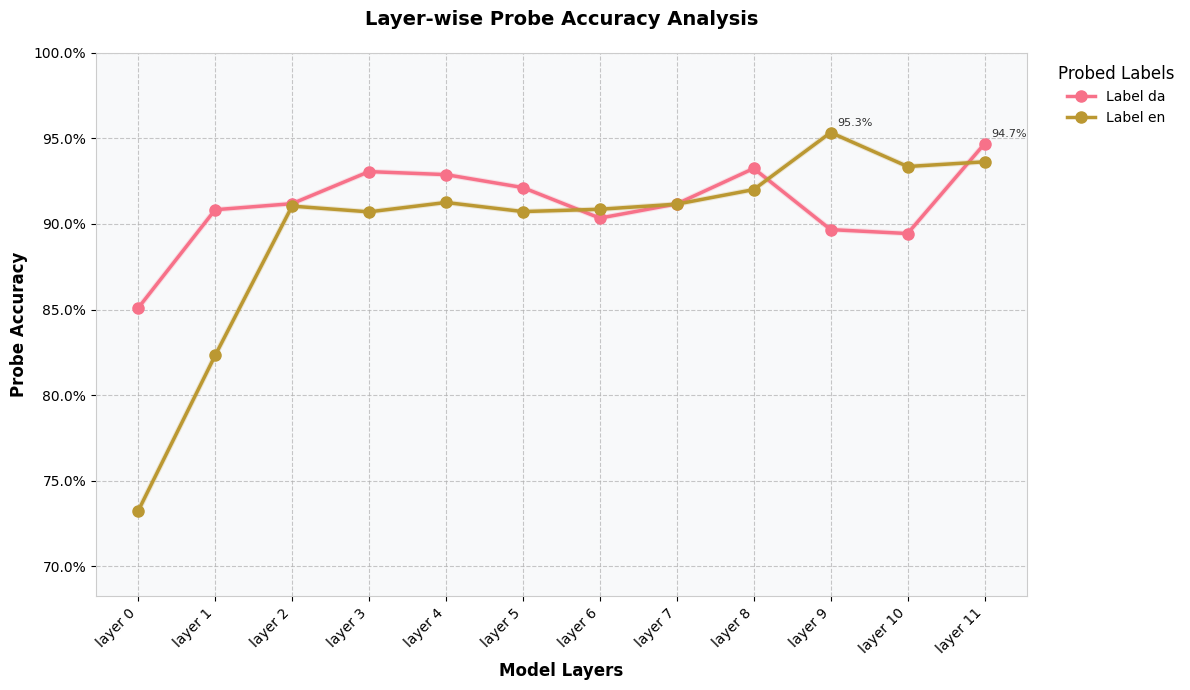

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import PercentFormatter
import seaborn as sns

# Set style
#plt.style.use('seaborn')
sns.set_palette("husl")

# Example data structure (replace with your actual data)
idk = {
    f"layer {i}": value.class_accuracies for i, value in enumerate(probe_by_layer.values())
}

# Convert to DataFrame
df = pd.DataFrame(idk).T

# Create figure with specific size and DPI for clarity
fig, ax = plt.subplots(figsize=(12, 7), dpi=100)

# Plot lines with enhanced styling
for column in df.columns:
    line = ax.plot(df.index, df[column], marker='o', markersize=8, 
                  linewidth=2.5, label=f"Label {map_lab[column]}")
    
    # Add subtle shadow effect
    ax.plot(df.index, df[column], alpha=0.2, linewidth=4, 
           color=line[0].get_color())

# Customize grid
ax.grid(True, linestyle='--', alpha=0.7)

# Customize background
ax.set_facecolor('#f8f9fa')
fig.patch.set_facecolor('#ffffff')

# Format y-axis as percentages
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

# Set axis limits with padding
ax.set_ylim(df.values.min() - 0.05, min(1.0, df.values.max() + 0.05))

# Customize labels and title
plt.xlabel('Model Layers', fontsize=12, fontweight='bold')
plt.ylabel('Probe Accuracy', fontsize=12, fontweight='bold')
plt.title('Layer-wise Probe Accuracy Analysis', fontsize=14, 
          fontweight='bold', pad=20)

# Enhance tick labels
plt.xticks(rotation=45, ha='right')
ax.tick_params(axis='both', which='major', labelsize=10)

# Add legend with custom styling
legend = plt.legend(title='Probed Labels', title_fontsize=12, 
                   fontsize=10, bbox_to_anchor=(1.02, 1), 
                   loc='upper left')
legend.get_frame().set_facecolor('#ffffff')
legend.get_frame().set_alpha(0.9)
legend.get_frame().set_linewidth(0)

# Add subtle box around plot
for spine in ax.spines.values():
    spine.set_edgecolor('#cccccc')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Optional: Add annotations for maximum values
for column in df.columns:
    max_val = df[column].max()
    max_idx = df[column].idxmax()
    ax.annotate(f'{max_val:.1%}',
                xy=(max_idx, max_val),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=8,
                alpha=0.8)

plt.show()